# Кластеризация

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [137]:
from sklearn.datasets import fetch_20newsgroups


train_data = fetch_20newsgroups(subset='train')
val_data = fetch_20newsgroups(subset='test')

len(train_data['data']), len(val_data['data'])

(11314, 7532)

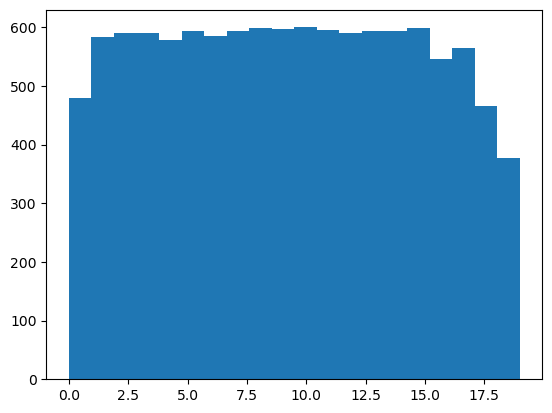

In [138]:
plt.hist(train_data['target'], bins=20)
None

## Text preprocessing

In [139]:
! pip install -qq spacy

In [140]:
from tqdm import tqdm
import re
from collections import Counter
from spacy.lang.en import stop_words


import nltk
from nltk.corpus import words
nltk.download('words')


DICT_WORDS_COUNT = 1000
stopwords = stop_words.STOP_WORDS

[nltk_data] Downloading package words to /Users/ktann/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [141]:
english_words_corpora = words.words()
len(english_words_corpora)

236736

In [142]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

In [143]:
def clean_text(text):

    if 'Lines:' in text:
        start = text.index('Lines:') + 5
        text = text[start:]

    text = text.lower()

    text = re.sub(r'[\w\d.]+@[\w\d]+.[\w\d]+', ' ', text)
    text = re.sub(r'(http|https)://[\w\d/.]+', ' ', text)

    text = re.sub(r'[^a-z]', ' ', text)

    text = re.sub(r'([^\w]|[-_])+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text)

    text = text.strip()
    
    # words = [
    #     w for w in text.split() \
    #         if len(w) > 3 and \
    #             w not in stopwords and \
    #             w in english_words_corpora
    # ]
    
    words = [
        stemmer.stem(w) for w in text.split() \
            if len(w) > 3 and \
                w not in stopwords
    ]

    

    return ' '.join(words)

In [144]:
text = train_data['data'][0]
print(text)
print()

print(clean_text(text))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






wonder enlighten door sport look late earli call bricklin door small addit bumper separ rest bodi know tellm model engin spec year product histori info funki look mail thank brought neighborhood lerxst


In [145]:
from random import randint, seed
import warnings
warnings.filterwarnings('ignore')

In [146]:
seed(4242)
# samples1000 = list(filter(lambda it: randint(0, 9) == 0, zip(train_data['data'], train_data['target'])))
samples1000 = list(zip(train_data['data'], train_data['target']))

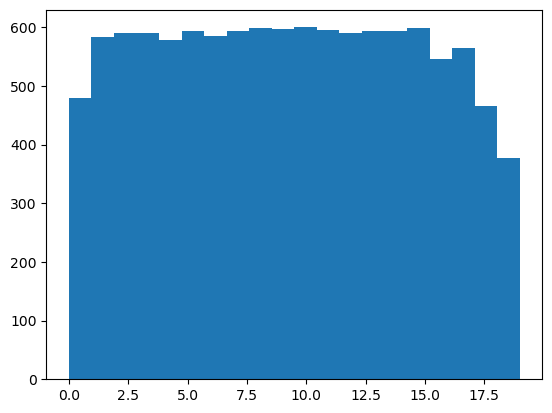

In [181]:
texts1000, targets1000 = zip(*samples1000)
plt.hist(targets1000, bins=20)
None

In [148]:
clean_train_texts = [
    clean_text(text) for text, target in tqdm(samples1000, desc='Train texts')
]

Train texts:   1%|          | 60/11314 [00:00<00:20, 558.37it/s]

Train texts: 100%|██████████| 11314/11314 [00:09<00:00, 1167.15it/s]


## LSI

In [149]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer

In [150]:
# Preprocess the text data and create a list of tokenized documents
tokenized_documents = [simple_preprocess(text) for text in clean_train_texts]

# Create a dictionary mapping of words to unique IDs
dictionary = corpora.Dictionary(tokenized_documents)

# Create a Bag of Words (BoW) representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

In [151]:
# Create a TF-IDF model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [152]:
# Train the LSI model (Latent Semantic Indexing)
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=20)

# Print the top topics and their top words
lsi_topics = lsi_model.print_topics(num_topics=20, num_words=10)
for topic in lsi_topics:
    print(topic)

# Get the document vectors
document_topic_vectors = []
for doc_bow in corpus_tfidf:
    document_topic_vector = lsi_model[doc_bow]
    document_topic_vectors.append(document_topic_vector)

# Get topic vectors for multiple documents
for i, doc_idx in enumerate([0, 1, 2, 3, 4], start=1):
    doc_bow = corpus_tfidf[doc_idx]
    document_topic_vector = lsi_model[doc_bow]
    print(f"Document {doc_idx}:")
    print(f"Topic Vector: {document_topic_vector}") 
    print(f'Doc vec len: {len(document_topic_vector)}')
    print()

(0, '0.115*"peopl" + 0.110*"window" + 0.100*"like" + 0.099*"know" + 0.097*"think" + 0.094*"system" + 0.091*"drive" + 0.090*"post" + 0.088*"time" + 0.083*"articl"')
(1, '-0.321*"window" + -0.194*"card" + -0.188*"drive" + -0.178*"file" + 0.152*"christian" + -0.133*"driver" + -0.128*"scsi" + 0.126*"peopl" + -0.123*"disk" + -0.121*"thank"')
(2, '-0.397*"game" + -0.298*"team" + -0.206*"player" + -0.178*"play" + 0.159*"encrypt" + -0.147*"hockey" + -0.140*"season" + -0.135*"score" + 0.120*"chip" + -0.113*"year"')
(3, '0.324*"encrypt" + 0.283*"chip" + -0.273*"window" + -0.234*"christian" + 0.196*"clipper" + -0.170*"jesus" + 0.163*"escrow" + 0.160*"govern" + 0.156*"secur" + 0.136*"key"')
(4, '-0.545*"drive" + -0.389*"scsi" + 0.328*"window" + 0.205*"file" + -0.152*"disk" + -0.123*"hard" + -0.122*"floppi" + -0.116*"control" + 0.106*"program" + 0.098*"encrypt"')
(5, '0.329*"israel" + 0.297*"isra" + 0.263*"armenian" + -0.221*"christian" + 0.218*"arab" + -0.174*"jesus" + 0.142*"jew" + 0.138*"turkish

In [153]:
df = pd.DataFrame(targets1000, columns=['target'])
df

,target
0,7
1,4
2,4
3,1
4,14
...,...
11309,13
11310,4
11311,3
11312,1


In [154]:
docs_vectors = []

for doc_idx in tqdm(range(len(df))):
    doc_bow = corpus_tfidf[doc_idx]
    document_topic_vector = lsi_model[doc_bow]

    if document_topic_vector:
        _, vec = zip(*document_topic_vector)
    else:
        vec = [None] * 20

    docs_vectors.append(vec)

  0%|          | 0/11314 [00:00<?, ?it/s]

100%|██████████| 11314/11314 [00:00<00:00, 11684.50it/s]


In [155]:
len(docs_vectors)

11314

In [156]:
df[[f'vec{i}' for i in range(20)]] = docs_vectors

In [157]:
df

,target,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,...,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19
0,7,0.091618,-0.017080,-0.026477,0.008553,0.005739,-0.003637,-0.050546,-0.008533,-0.012564,...,-0.043595,0.001613,0.005616,0.032275,-0.011860,-0.010521,0.031719,0.000107,-0.020996,-0.022616
1,4,0.123453,-0.095200,-0.013703,0.006456,-0.080085,-0.000844,-0.002556,-0.047288,-0.004466,...,-0.004718,-0.023910,0.014210,-0.036648,0.004429,0.012500,-0.020317,0.025181,0.055871,-0.027399
2,4,0.201728,-0.053911,-0.032236,-0.017596,-0.011807,-0.011325,-0.034864,-0.015566,-0.016968,...,-0.034886,-0.009230,0.012179,0.003613,0.012814,-0.059716,-0.030376,0.016258,0.002728,-0.014544
3,1,0.143613,-0.049683,0.018121,0.070074,0.032555,-0.055665,-0.005183,-0.037359,-0.009387,...,-0.025698,-0.017277,-0.048996,0.065809,0.009837,0.043282,-0.034481,0.025574,-0.002150,-0.020718
4,14,0.115541,-0.017422,0.015737,-0.016623,0.006869,-0.022160,-0.000261,0.006805,-0.009312,...,0.037934,0.021117,-0.037126,-0.018410,-0.004882,0.004887,-0.030754,-0.006198,0.025299,0.000728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,13,0.082163,0.023151,0.001725,-0.002567,0.002466,-0.008308,-0.031117,0.003810,0.001310,...,0.010666,0.005435,0.005286,0.000750,-0.007026,-0.044945,-0.010207,0.047340,-0.009342,-0.039620
11310,4,0.102327,-0.093807,-0.005192,-0.005263,-0.085262,0.003762,0.001505,-0.019515,0.006528,...,-0.012076,-0.014860,-0.012324,-0.088476,0.039632,-0.020075,-0.029582,0.056829,-0.028279,0.027368
11311,3,0.056277,-0.033313,0.008136,0.031144,-0.033599,-0.011463,0.004498,-0.023956,0.010758,...,-0.014341,0.020452,-0.019240,-0.031079,0.026140,-0.015599,-0.035902,0.011242,0.033382,-0.004349
11312,1,0.116329,-0.006539,0.000762,-0.003838,0.031931,-0.008960,-0.050017,0.002274,-0.037692,...,0.056522,0.012212,0.012247,0.013109,-0.001928,0.007256,0.000618,0.035115,-0.039731,-0.000443


In [158]:
dff = df.dropna()
dff

,target,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,...,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19
0,7,0.091618,-0.017080,-0.026477,0.008553,0.005739,-0.003637,-0.050546,-0.008533,-0.012564,...,-0.043595,0.001613,0.005616,0.032275,-0.011860,-0.010521,0.031719,0.000107,-0.020996,-0.022616
1,4,0.123453,-0.095200,-0.013703,0.006456,-0.080085,-0.000844,-0.002556,-0.047288,-0.004466,...,-0.004718,-0.023910,0.014210,-0.036648,0.004429,0.012500,-0.020317,0.025181,0.055871,-0.027399
2,4,0.201728,-0.053911,-0.032236,-0.017596,-0.011807,-0.011325,-0.034864,-0.015566,-0.016968,...,-0.034886,-0.009230,0.012179,0.003613,0.012814,-0.059716,-0.030376,0.016258,0.002728,-0.014544
3,1,0.143613,-0.049683,0.018121,0.070074,0.032555,-0.055665,-0.005183,-0.037359,-0.009387,...,-0.025698,-0.017277,-0.048996,0.065809,0.009837,0.043282,-0.034481,0.025574,-0.002150,-0.020718
4,14,0.115541,-0.017422,0.015737,-0.016623,0.006869,-0.022160,-0.000261,0.006805,-0.009312,...,0.037934,0.021117,-0.037126,-0.018410,-0.004882,0.004887,-0.030754,-0.006198,0.025299,0.000728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,13,0.082163,0.023151,0.001725,-0.002567,0.002466,-0.008308,-0.031117,0.003810,0.001310,...,0.010666,0.005435,0.005286,0.000750,-0.007026,-0.044945,-0.010207,0.047340,-0.009342,-0.039620
11310,4,0.102327,-0.093807,-0.005192,-0.005263,-0.085262,0.003762,0.001505,-0.019515,0.006528,...,-0.012076,-0.014860,-0.012324,-0.088476,0.039632,-0.020075,-0.029582,0.056829,-0.028279,0.027368
11311,3,0.056277,-0.033313,0.008136,0.031144,-0.033599,-0.011463,0.004498,-0.023956,0.010758,...,-0.014341,0.020452,-0.019240,-0.031079,0.026140,-0.015599,-0.035902,0.011242,0.033382,-0.004349
11312,1,0.116329,-0.006539,0.000762,-0.003838,0.031931,-0.008960,-0.050017,0.002274,-0.037692,...,0.056522,0.012212,0.012247,0.013109,-0.001928,0.007256,0.000618,0.035115,-0.039731,-0.000443


## Clusterisation

In [182]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, v_measure_score

In [184]:
# DBSCAN

if 'cluster' in dff.columns:
    dff.drop('cluster', axis=1, inplace=True)

clusterisator = DBSCAN(eps=0.055, min_samples=2)
dff['cluster'] = clusterisator.fit_predict(dff.drop('target', axis=1))

print('silhouette:', silhouette_score(dff.drop(['target', 'cluster'], axis=1), dff['cluster']))
print(' v-measure:', v_measure_score(dff['target'], dff['cluster']))

silhouette: -0.4205303782827343
 v-measure: 0.20151607049629372


In [161]:
dff[['cluster', 'target']]

,cluster,target
0,0,7
1,-1,4
2,-1,4
3,-1,1
4,-1,14
...,...,...
11309,0,13
11310,-1,4
11311,529,3
11312,-1,1


In [162]:
len(dff['cluster'].value_counts().to_dict()) - 1

531

In [163]:
dff['cluster'].value_counts().to_dict()

{0: 5243,
 -1: 4614,
 144: 32,
 58: 18,
 23: 17,
 44: 17,
 91: 13,
 160: 13,
 179: 12,
 229: 10,
 18: 9,
 69: 9,
 72: 9,
 232: 8,
 27: 8,
 88: 8,
 125: 8,
 226: 8,
 38: 8,
 220: 7,
 172: 7,
 325: 7,
 366: 6,
 306: 6,
 92: 6,
 86: 6,
 208: 6,
 28: 6,
 119: 5,
 43: 5,
 195: 5,
 279: 5,
 25: 5,
 209: 5,
 396: 5,
 12: 5,
 188: 5,
 146: 5,
 8: 5,
 268: 4,
 197: 4,
 184: 4,
 412: 4,
 65: 4,
 85: 4,
 174: 4,
 73: 4,
 70: 4,
 260: 4,
 115: 4,
 114: 4,
 237: 4,
 420: 4,
 251: 4,
 164: 4,
 228: 4,
 457: 4,
 250: 4,
 249: 4,
 127: 4,
 448: 4,
 442: 4,
 379: 4,
 194: 4,
 142: 4,
 204: 4,
 332: 4,
 284: 4,
 303: 4,
 31: 4,
 10: 4,
 312: 4,
 20: 4,
 39: 4,
 335: 4,
 47: 4,
 66: 3,
 299: 3,
 305: 3,
 157: 3,
 516: 3,
 155: 3,
 329: 3,
 151: 3,
 150: 3,
 456: 3,
 236: 3,
 453: 3,
 381: 3,
 380: 3,
 224: 3,
 334: 3,
 40: 3,
 447: 3,
 223: 3,
 327: 3,
 118: 3,
 398: 3,
 207: 3,
 321: 3,
 405: 3,
 3: 3,
 5: 3,
 314: 3,
 189: 3,
 213: 3,
 214: 3,
 182: 3,
 181: 3,
 311: 3,
 178: 3,
 176: 3,
 14: 3,
 218: 

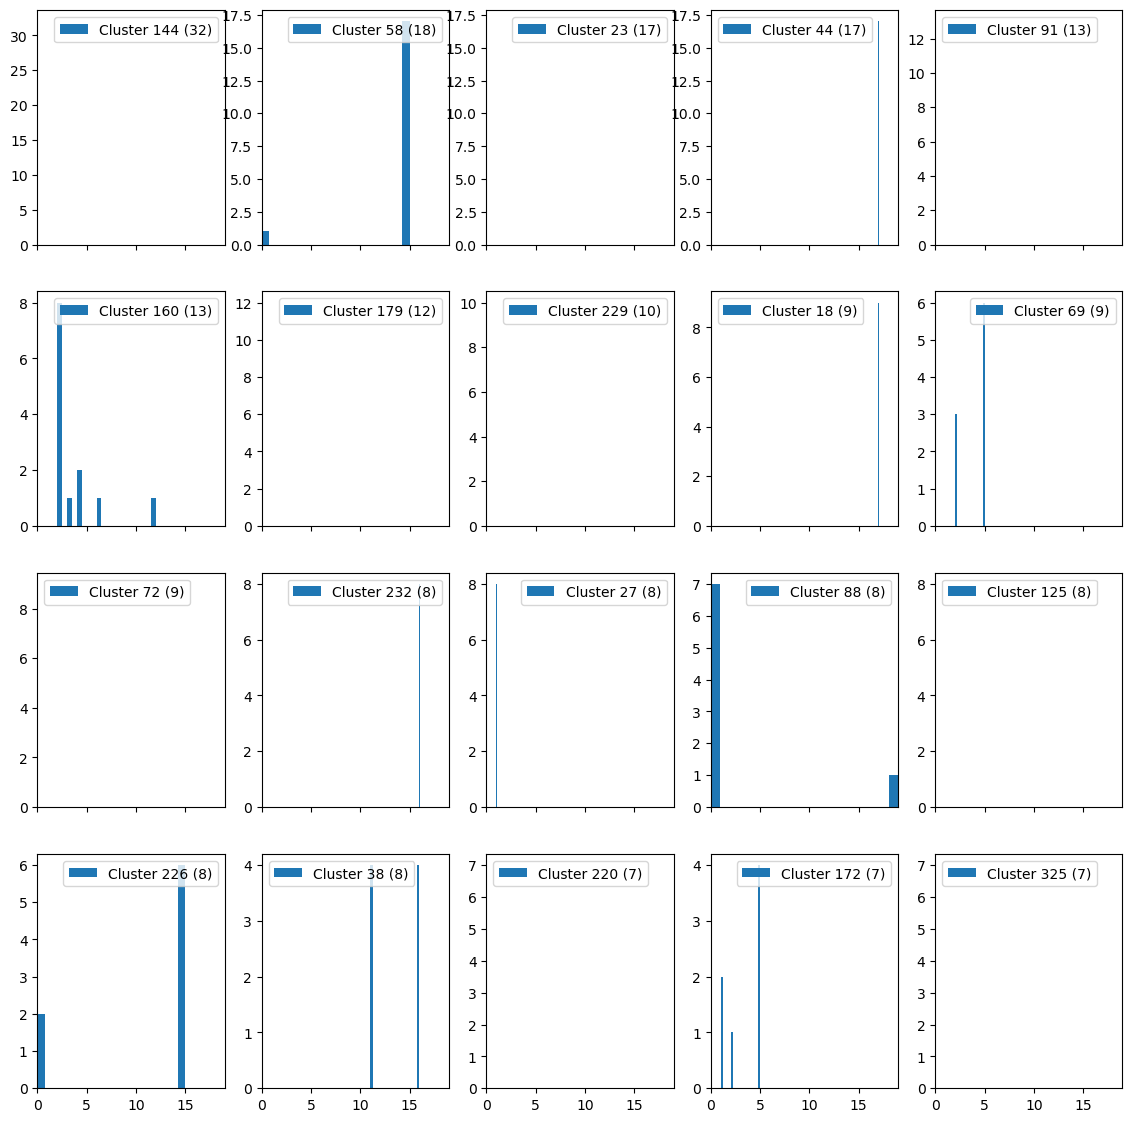

In [164]:
fig, axs = plt.subplots(4, 5, figsize=(14, 14), sharex=True, sharey=False)
axs = axs.flatten()

for i, ax in zip(list(dff['cluster'].value_counts().to_dict().keys())[2:], axs):
    dist = dff[dff['cluster'] == i]['target']
    ax.hist(dist, bins=20, label=f'Cluster {i} ({len(dist)})')
    ax.set_xlim(0, 19)
    ax.legend()

In [189]:
# k-Means

sil = []
vmeas = []

for i in range(10):
    if 'cluster' in dff.columns:
        dff.drop('cluster', axis=1, inplace=True)

    clusterisator = KMeans(n_clusters=20)
    dff['cluster'] = clusterisator.fit_predict(dff.drop('target', axis=1))

    sil.append(silhouette_score(dff.drop(['target', 'cluster'], axis=1), dff['cluster']))
    vmeas.append(v_measure_score(dff['target'], dff['cluster']))

print('silhouette:', sum(sil) / len(sil))
print(' v-measure:', sum(vmeas) / len(vmeas))

silhouette: 0.17827272818604029
 v-measure: 0.40029743299511117


In [167]:
dff['cluster'].value_counts().to_dict()

{1: 2941,
 19: 1248,
 12: 1224,
 17: 1075,
 2: 722,
 11: 668,
 5: 534,
 18: 375,
 9: 350,
 6: 333,
 0: 287,
 16: 265,
 3: 248,
 8: 241,
 7: 226,
 4: 211,
 15: 122,
 14: 99,
 13: 69,
 10: 61}

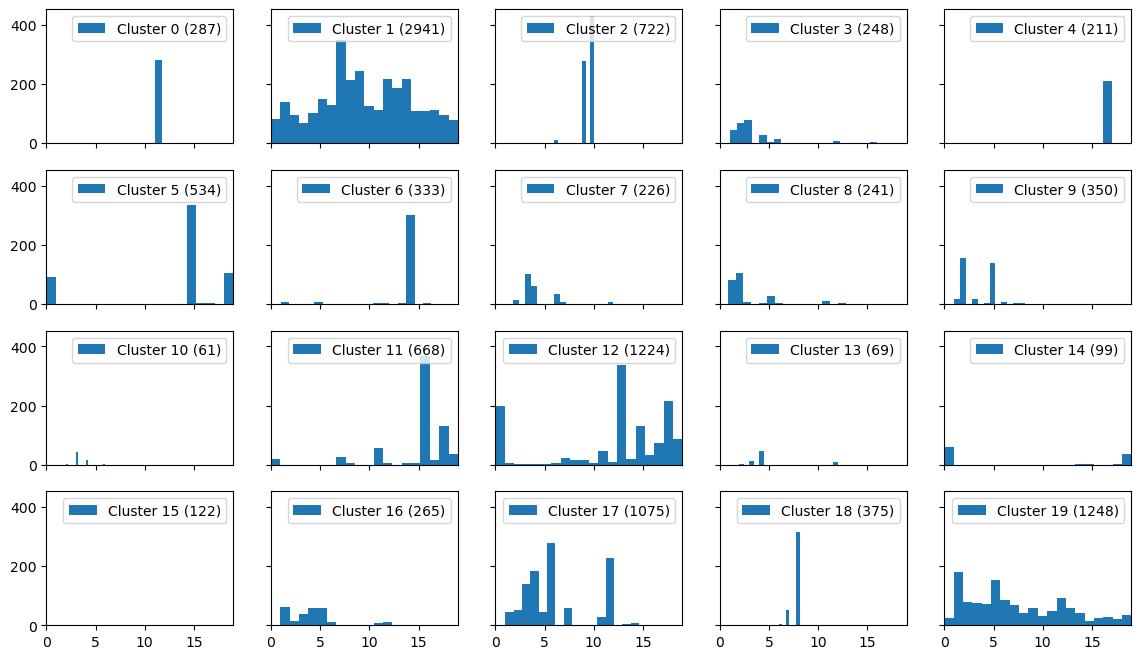

In [168]:
fig, axs = plt.subplots(4, 5, figsize=(14, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    dist = dff[dff['cluster'] == i]['target']
    ax.hist(dist, bins=20, label=f'Cluster {i} ({len(dist)})')
    ax.set_xlim(0, 19)
    ax.legend()

In [186]:
# Agglomerative

if 'cluster' in dff.columns:
    dff.drop('cluster', axis=1, inplace=True)

clusterisator = AgglomerativeClustering(n_clusters=20)
dff['cluster'] = clusterisator.fit_predict(dff.drop('target', axis=1))

print('silhouette:', silhouette_score(dff.drop(['target', 'cluster'], axis=1), dff['cluster']))
print(' v-measure:', v_measure_score(dff['target'], dff['cluster']))

silhouette: 0.14058413815423657
 v-measure: 0.44591708485300124


In [178]:
dff['cluster'].value_counts().to_dict()

{8: 3260,
 18: 1202,
 17: 1112,
 3: 1023,
 2: 990,
 10: 645,
 0: 454,
 5: 424,
 13: 331,
 4: 303,
 6: 278,
 11: 217,
 19: 185,
 15: 177,
 9: 164,
 7: 143,
 1: 133,
 16: 108,
 14: 88,
 12: 62}

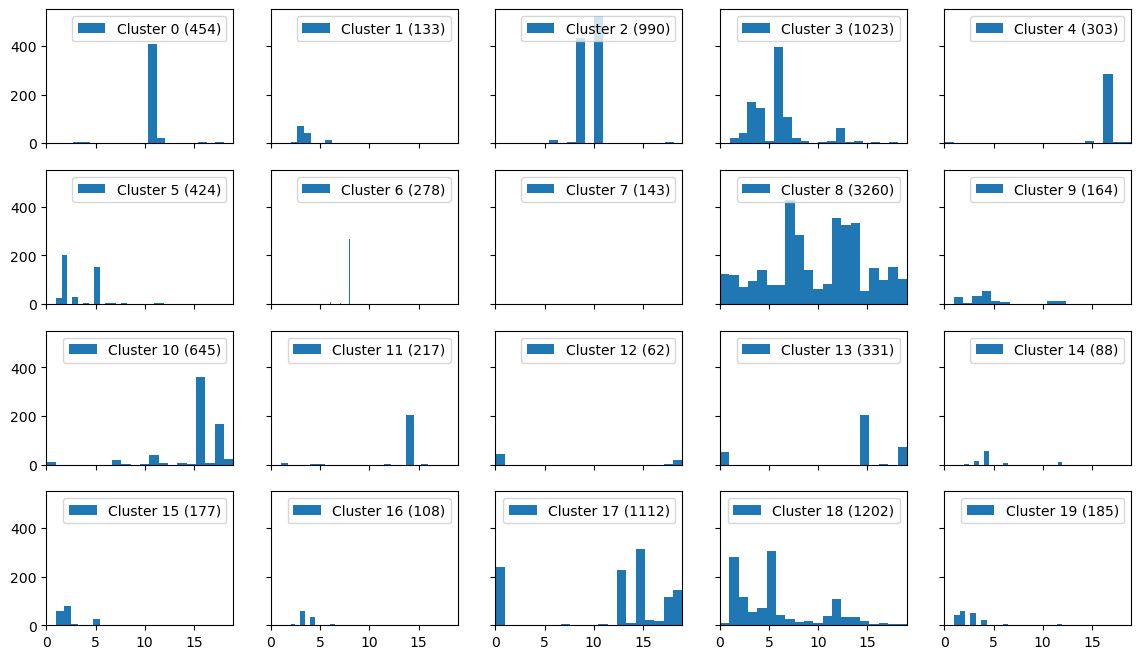

In [179]:
fig, axs = plt.subplots(4, 5, figsize=(14, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    dist = dff[dff['cluster'] == i]['target']
    ax.hist(dist, bins=20, label=f'Cluster {i} ({len(dist)})')
    ax.set_xlim(0, 19)
    ax.legend()